In [72]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import warnings
import sys
import xgboost as xgb
import optuna
from lazypredict.Supervised import LazyRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV, ElasticNetCV, LassoCV, LassoLarsCV, LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error
sys.path.append("..") 
%matplotlib inline

In [73]:
#读取数据
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
combined_df = pd.concat([train_data,test_data],axis=0)
#头5条数据
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.00,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.00,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.00,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.00,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.00,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [74]:
#训练数据大小
train_data.shape

(1460, 81)

In [75]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [76]:
#训练数据类型统计
train_dtype = train_data.dtypes
train_dtype.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [77]:
#训练数据信息
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.00,1460.00,1201.00,1460.00,1460.00,1460.00,1460.00,1460.00,1452.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1379.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00
mean,730.50,56.90,70.05,10516.83,6.10,5.58,1971.27,1984.87,103.69,443.64,46.55,567.24,1057.43,1162.63,346.99,5.84,1515.46,0.43,0.06,1.57,0.38,2.87,1.05,6.52,0.61,1978.51,1.77,472.98,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,2007.82,180921.20
std,421.61,42.30,24.28,9981.26,1.38,1.11,30.20,20.65,181.07,456.10,161.32,441.87,438.71,386.59,436.53,48.62,525.48,0.52,0.24,0.55,0.50,0.82,0.22,1.63,0.64,24.69,0.75,213.80,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33,79442.50
min,1.00,20.00,21.00,1300.00,1.00,1.00,1872.00,1950.00,0.00,0.00,0.00,0.00,0.00,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,1900.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2006.00,34900.00
25%,365.75,20.00,59.00,7553.50,5.00,5.00,1954.00,1967.00,0.00,0.00,0.00,223.00,795.75,882.00,0.00,0.00,1129.50,0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,1961.00,1.00,334.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,2007.00,129975.00
50%,730.50,50.00,69.00,9478.50,6.00,5.00,1973.00,1994.00,0.00,383.50,0.00,477.50,991.50,1087.00,0.00,0.00,1464.00,0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,1980.00,2.00,480.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,2008.00,163000.00
75%,1095.25,70.00,80.00,11601.50,7.00,6.00,2000.00,2004.00,166.00,712.25,0.00,808.00,1298.25,1391.25,728.00,0.00,1776.75,1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,2002.00,2.00,576.00,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,2009.00,214000.00
max,1460.00,190.00,313.00,215245.00,10.00,9.00,2010.00,2010.00,1600.00,5644.00,1474.00,2336.00,6110.00,4692.00,2065.00,572.00,5642.00,3.00,2.00,3.00,2.00,8.00,3.00,14.00,3.00,2010.00,4.00,1418.00,857.00,547.00,552.00,508.00,480.00,738.00,15500.00,12.00,2010.00,755000.00


In [78]:
#训练数据中的空值排序前20个
train_data.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

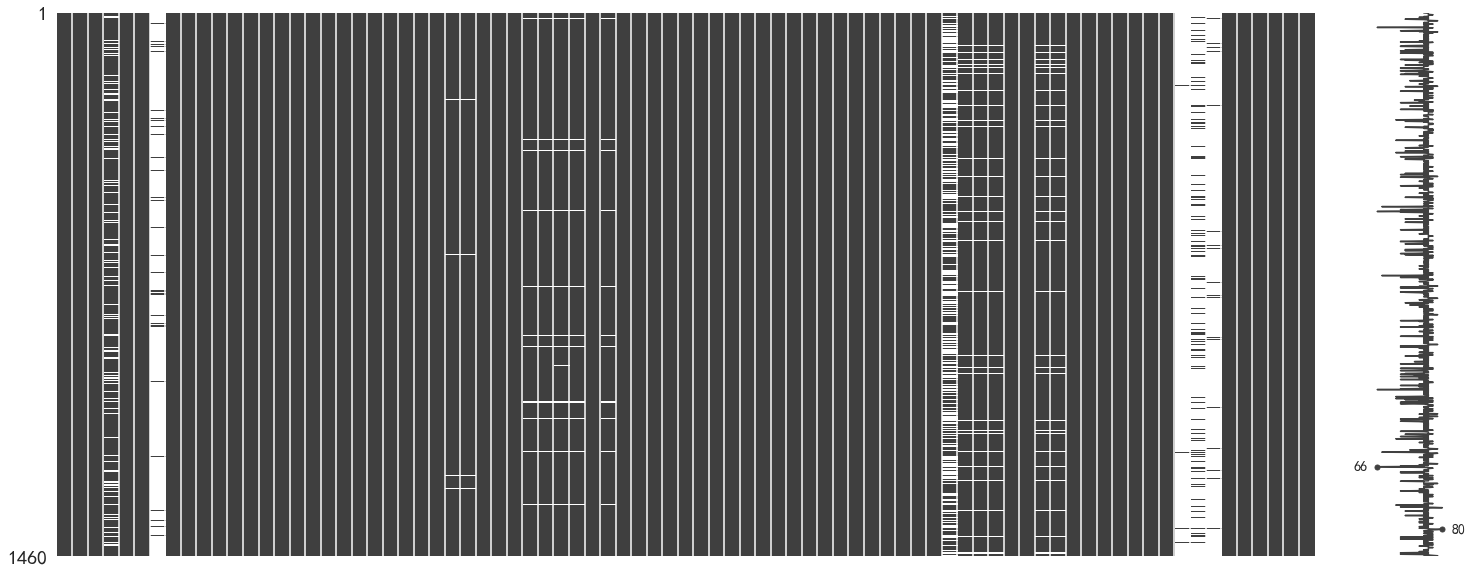

In [79]:
#可视化缺省值
msno.matrix(train_data)

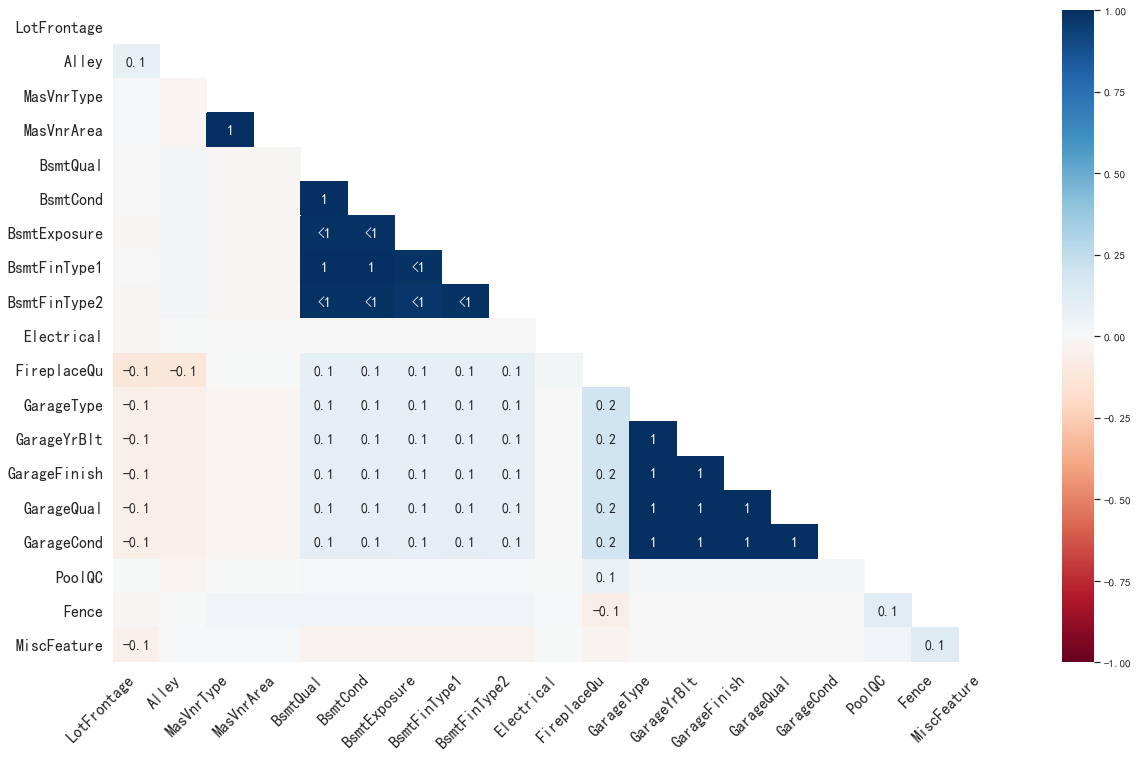

In [80]:
# 使用misingno查看缺失数据之间的相关性：表征一个变量的存在和不存在如何强烈地影响另一个的存在
# （比如说如果rate1和rate2的热度值是1,那么rate11缺失，rate2也必然缺失，两者在缺失性之间是直接相关的）
msno.heatmap(train_data)

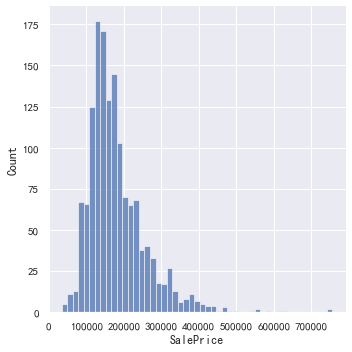

In [81]:
# 查看训练数据对应价格的分布
sns.displot(train_data['SalePrice'])

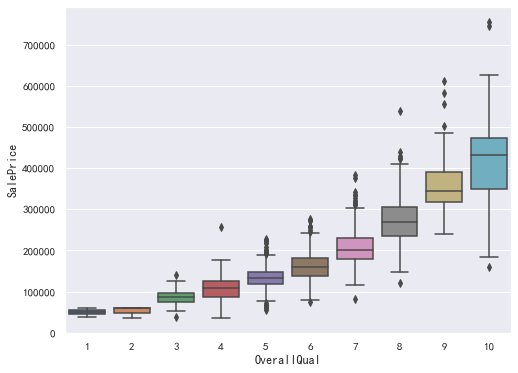

In [82]:
# 可以看到整体评分越高其价格是越高的
overallQual_SalePrice = pd.concat([train_data['SalePrice'],train_data['OverallQual']],axis=1)
plt.figure(figsize=(8,6))
sns.boxplot(x='OverallQual',y='SalePrice',data=overallQual_SalePrice)

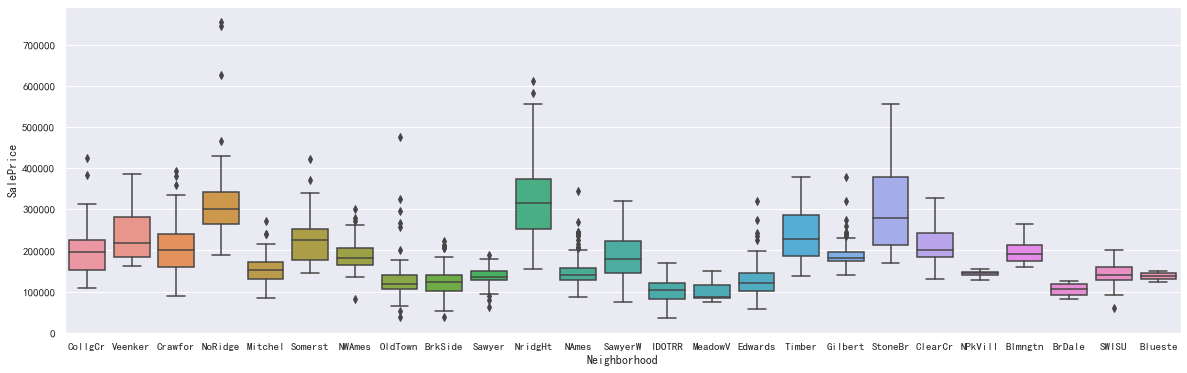

In [83]:
# 用箱状图查看一下离散非数值型数据的分布
# 可以看到如果neighorhood是在stoneBr和NridgHt附近的话，价格会较高
Neighborhood_SalePrice = pd.concat([train_data['SalePrice'],train_data['Neighborhood']],axis=1)
plt.figure(figsize=(20,6))
sns.boxplot(x='Neighborhood',y='SalePrice',data=Neighborhood_SalePrice)

<Figure size 576x432 with 0 Axes>

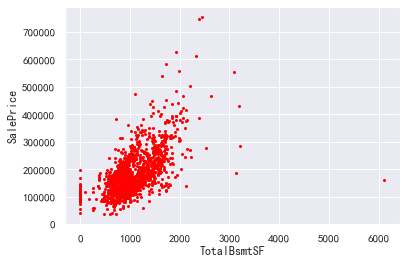

In [84]:
# 绘制和价格相关的特征的散点图
TotalBsmtSF_SalePrice = pd.concat([train_data['SalePrice'],train_data['TotalBsmtSF']],axis=1)
plt.figure(figsize=(8,6))
TotalBsmtSF_SalePrice.plot.scatter(x='TotalBsmtSF',y='SalePrice',s=4,c='red')

In [85]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,CBlock,TA,TA,No,Rec,468.00,LwQ,144.00,270.00,882.00,GasA,TA,Y,SBrkr,896,0,0,896,0.00,0.00,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.00,Unf,1.00,730.00,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.00,TA,TA,CBlock,TA,TA,No,ALQ,923.00,Unf,0.00,406.00,1329.00,GasA,TA,Y,SBrkr,1329,0,0,1329,0.00,0.00,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.00,Unf,1.00,312.00,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,PConc,Gd,TA,No,GLQ,791.00,Unf,0.00,137.00,928.00,GasA,Gd,Y,SBrkr,928,701,0,1629,0.00,0.00,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.00,Fin,2.00,482.00,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.00,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.00,TA,TA,PConc,TA,TA,No,GLQ,602.00,Unf,0.00,324.00,926.00,GasA,Ex,Y,SBrkr,926,678,0,1604,0.00,0.00,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.00,Fin,2.00,470.00,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.00,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.00,Gd,TA,PConc,Gd,TA,No,ALQ,263.00,Unf,0.00,1017.00,1280.00,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.00,0.00,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.00,RFn,2.00,506.00,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [86]:
# 查看测试数据中的数据类型统计
test_dtype = test_data.dtypes
test_dtype.value_counts()

object     43
int64      26
float64    11
dtype: int64

In [87]:
#测试数据集的数据大小
test_data.shape

(1459, 80)

In [88]:
#测试数据集缺省值前20
test_data.isnull().sum().sort_values(ascending = False).head(20)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageQual        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
dtype: int64

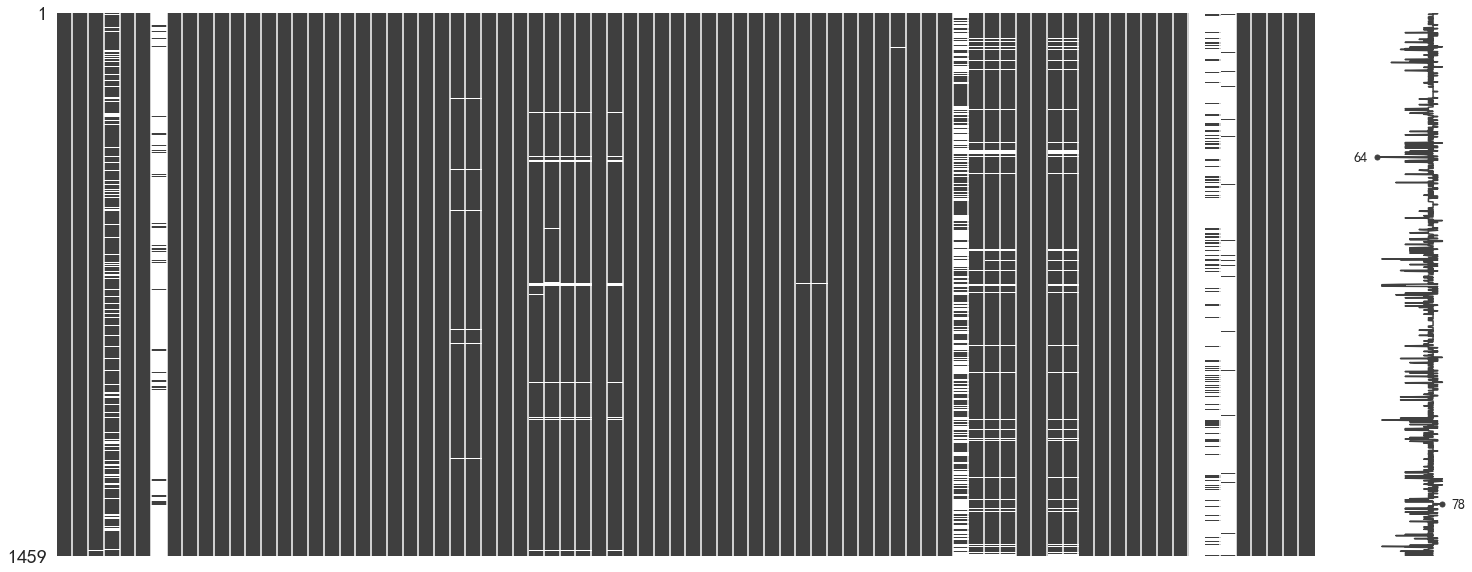

In [89]:
#缺失数据可视化
msno.matrix(test_data)

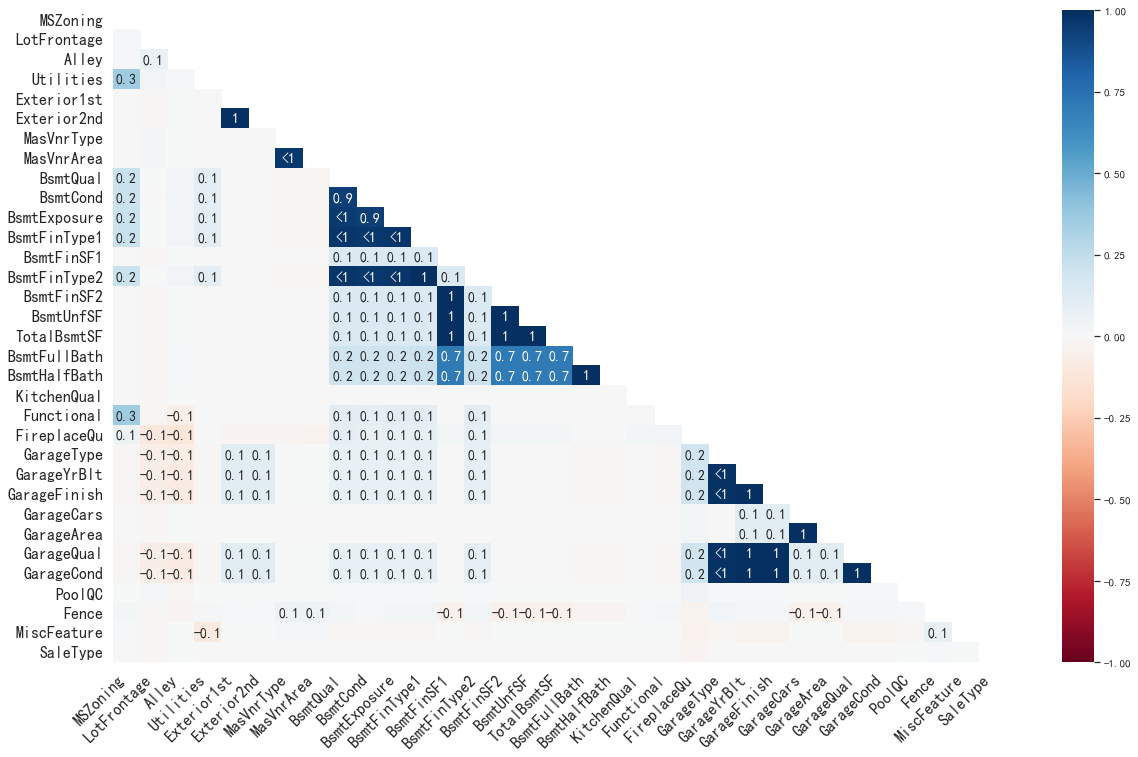

In [90]:
# 缺省值对比分析，可看出测试数据缺失比训练数据更严重
msno.heatmap(test_data)

In [97]:
numerical_features = [col for col in train_data.columns if train_data[col].dtypes != 'O']
discrete_features = [col for col in numerical_features if len(train_data[col].unique()) < 25 and col not in ['Id']]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features+['Id']]
categorical_features = [col for col in train_data.columns if train_data[col].dtype == 'O']

print("Total Number of Numerical Columns : ",len(numerical_features))
print("Number of discrete features : ",len(discrete_features))
print("No of continuous features are : ", len(continuous_features))
print("Number of non-numeric features : ",len(categorical_features))

Total Number of Numerical Columns :  38
Number of discrete features :  18
No of continuous features are :  19
Number of non-numeric features :  43


In [98]:
#打标签标识训练数据和测试数据
combined_df['Label'] = "test"
combined_df['Label'][:1460] = "Train"

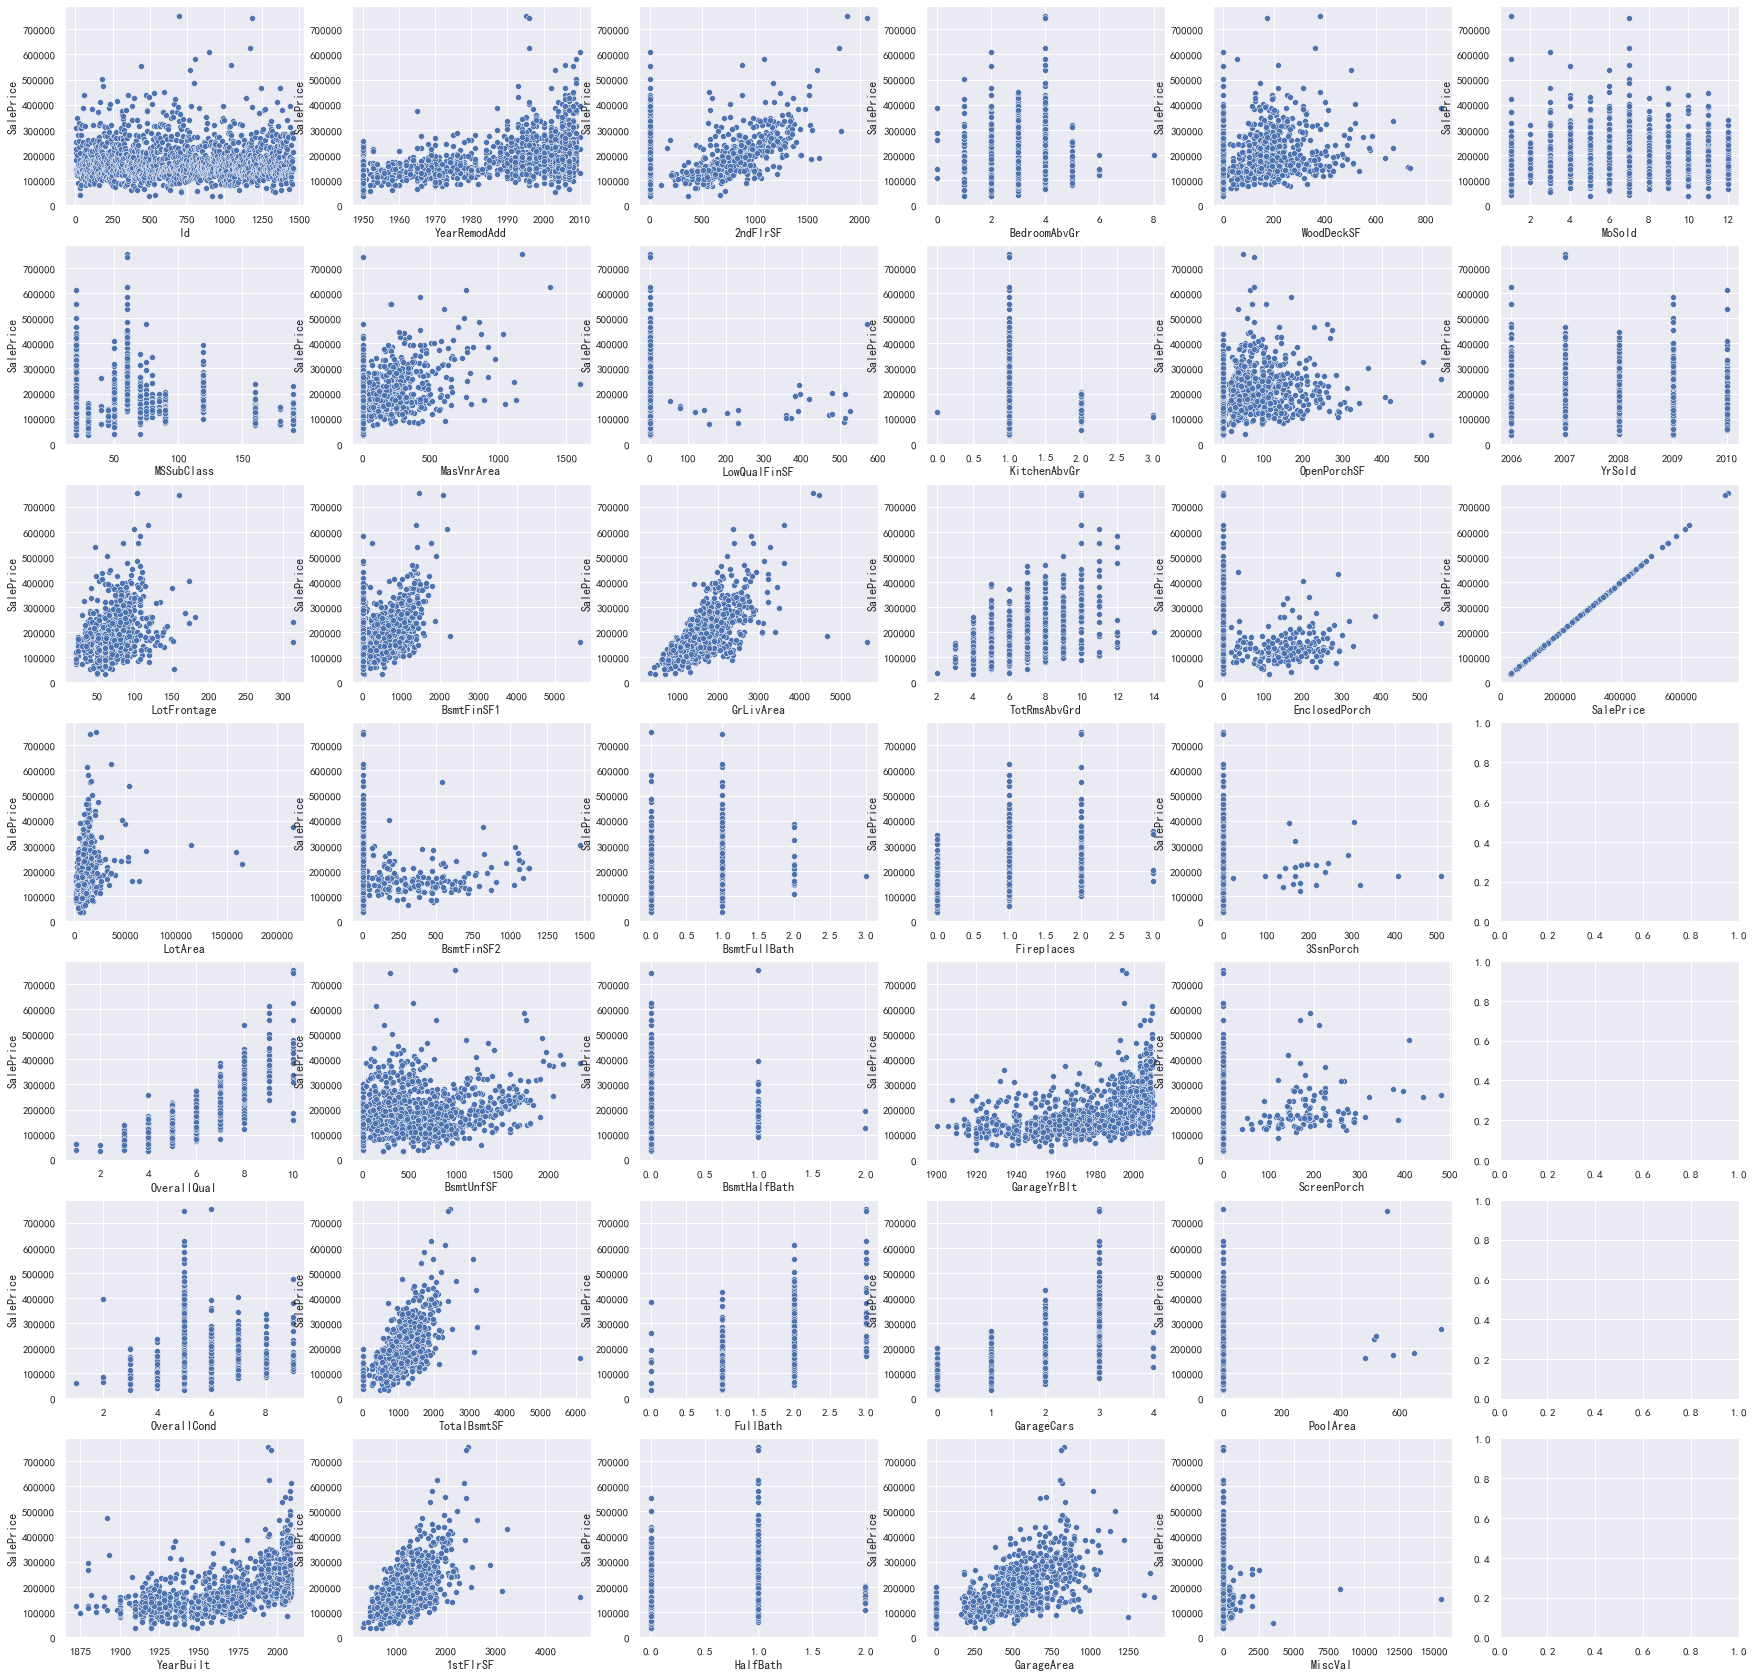

In [100]:
# 检查数值数据的线性分布
"""
横轴为数值数据特征，纵轴为价格标签
"""
f,axes = plt.subplots(7,6,figsize=(30,30),sharex=False)
for i,feature in enumerate(numerical_features):
    sns.scatterplot(data=combined_df,x=feature,y="SalePrice",ax=axes[i%7,i//7])

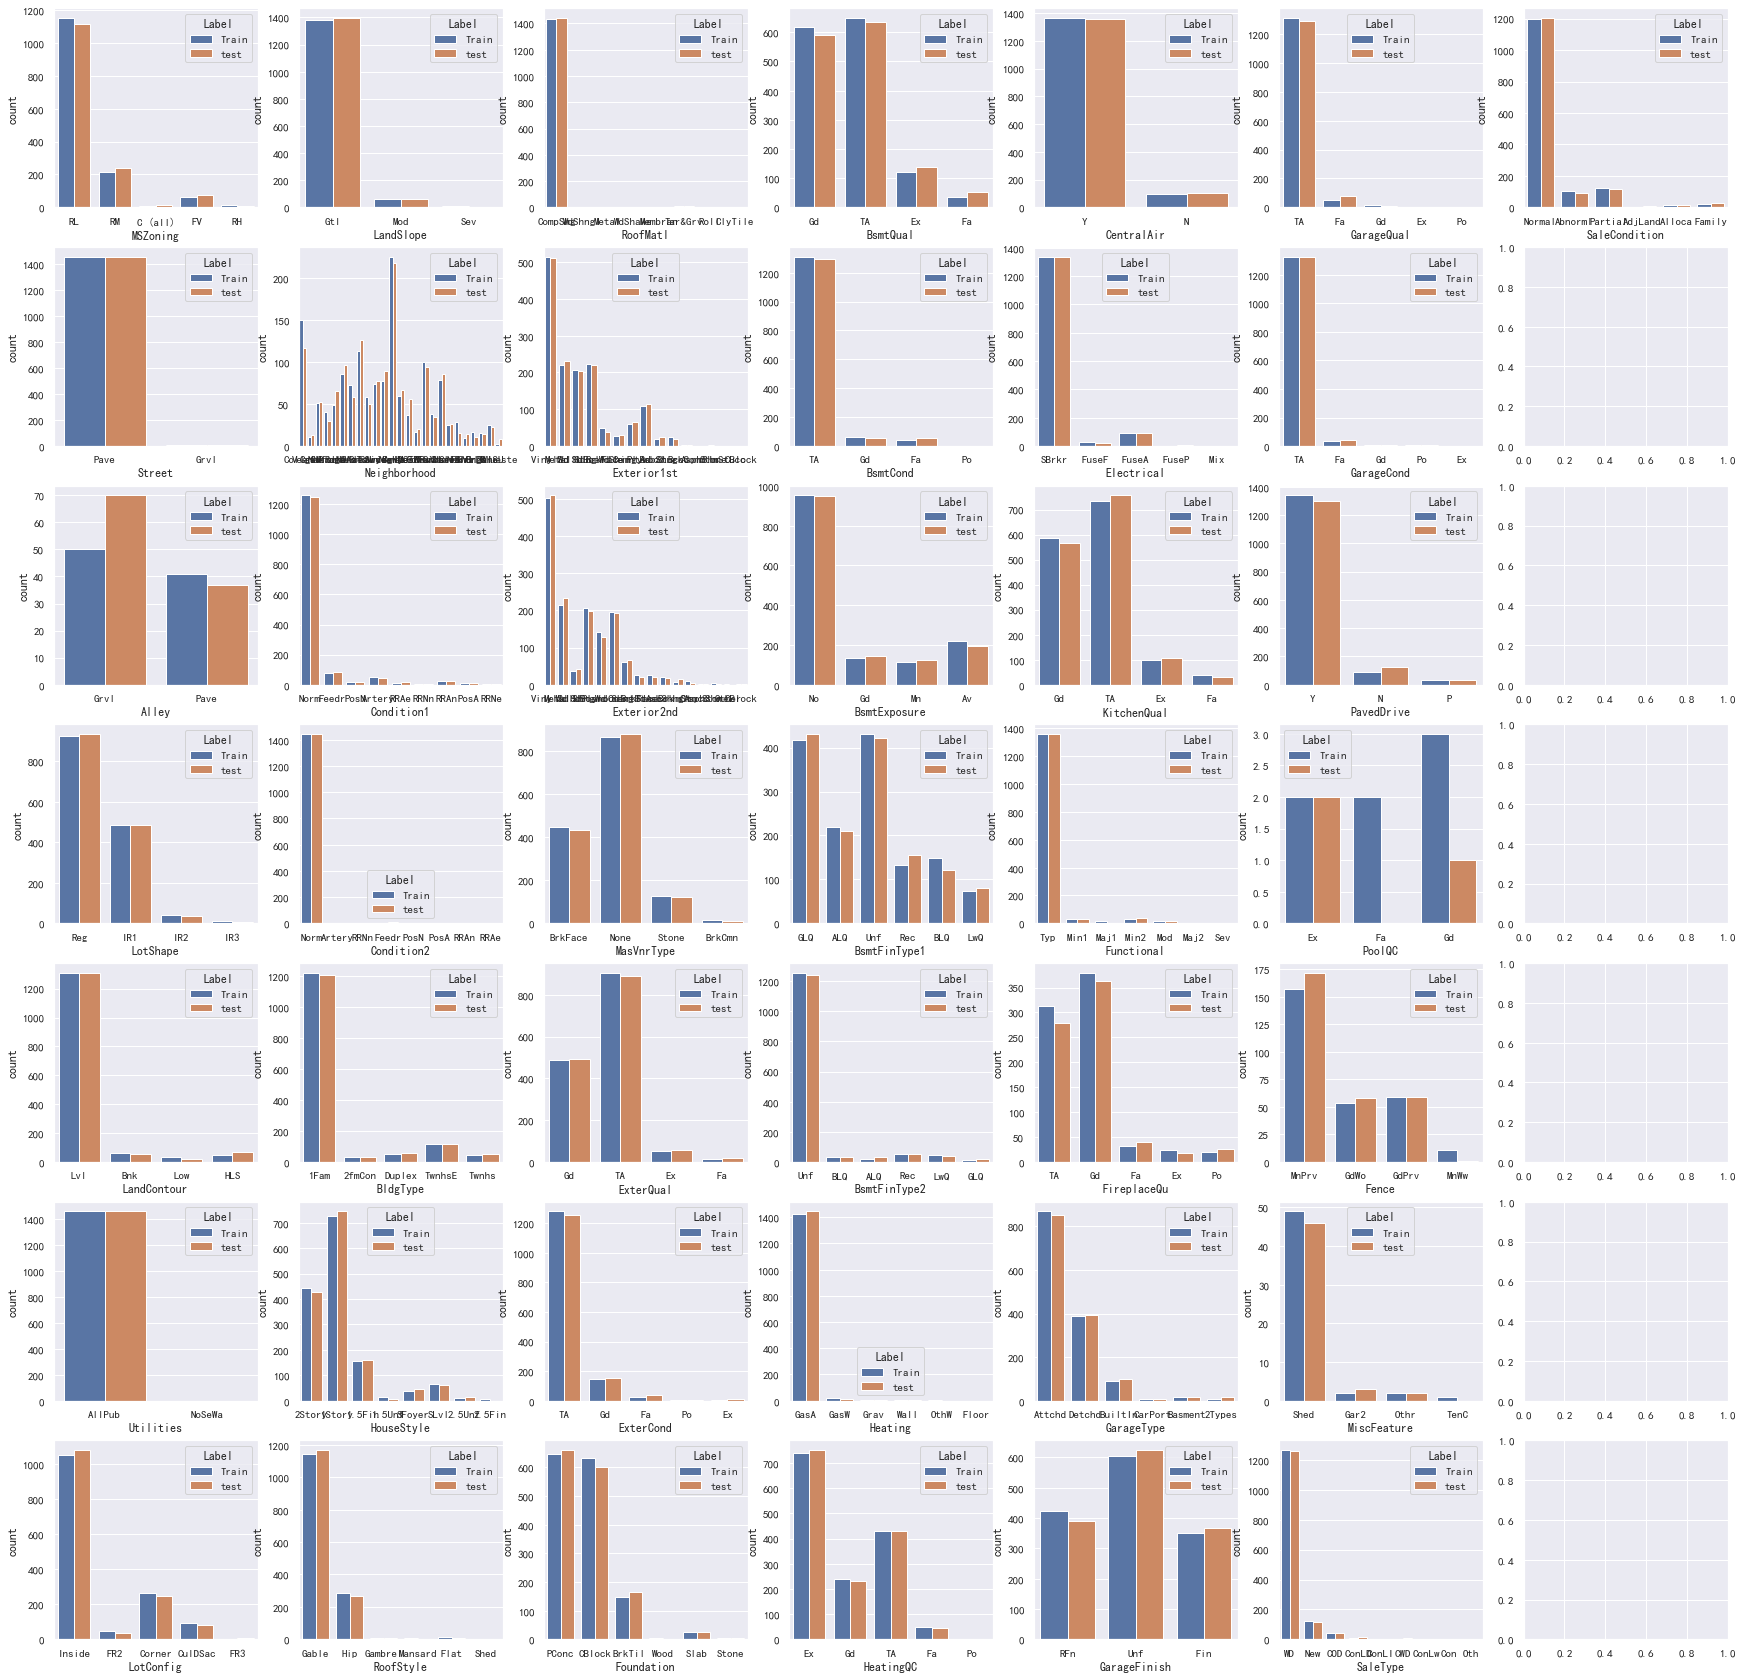

In [101]:
# 对比非数值型数据对比分析
f,axes = plt.subplots(7,7,figsize=(30,30),sharex=False)
for i,feature in enumerate(categorical_features):
    sns.countplot(data=combined_df,x=feature,hue="Label",ax=axes[i%7,i//7])

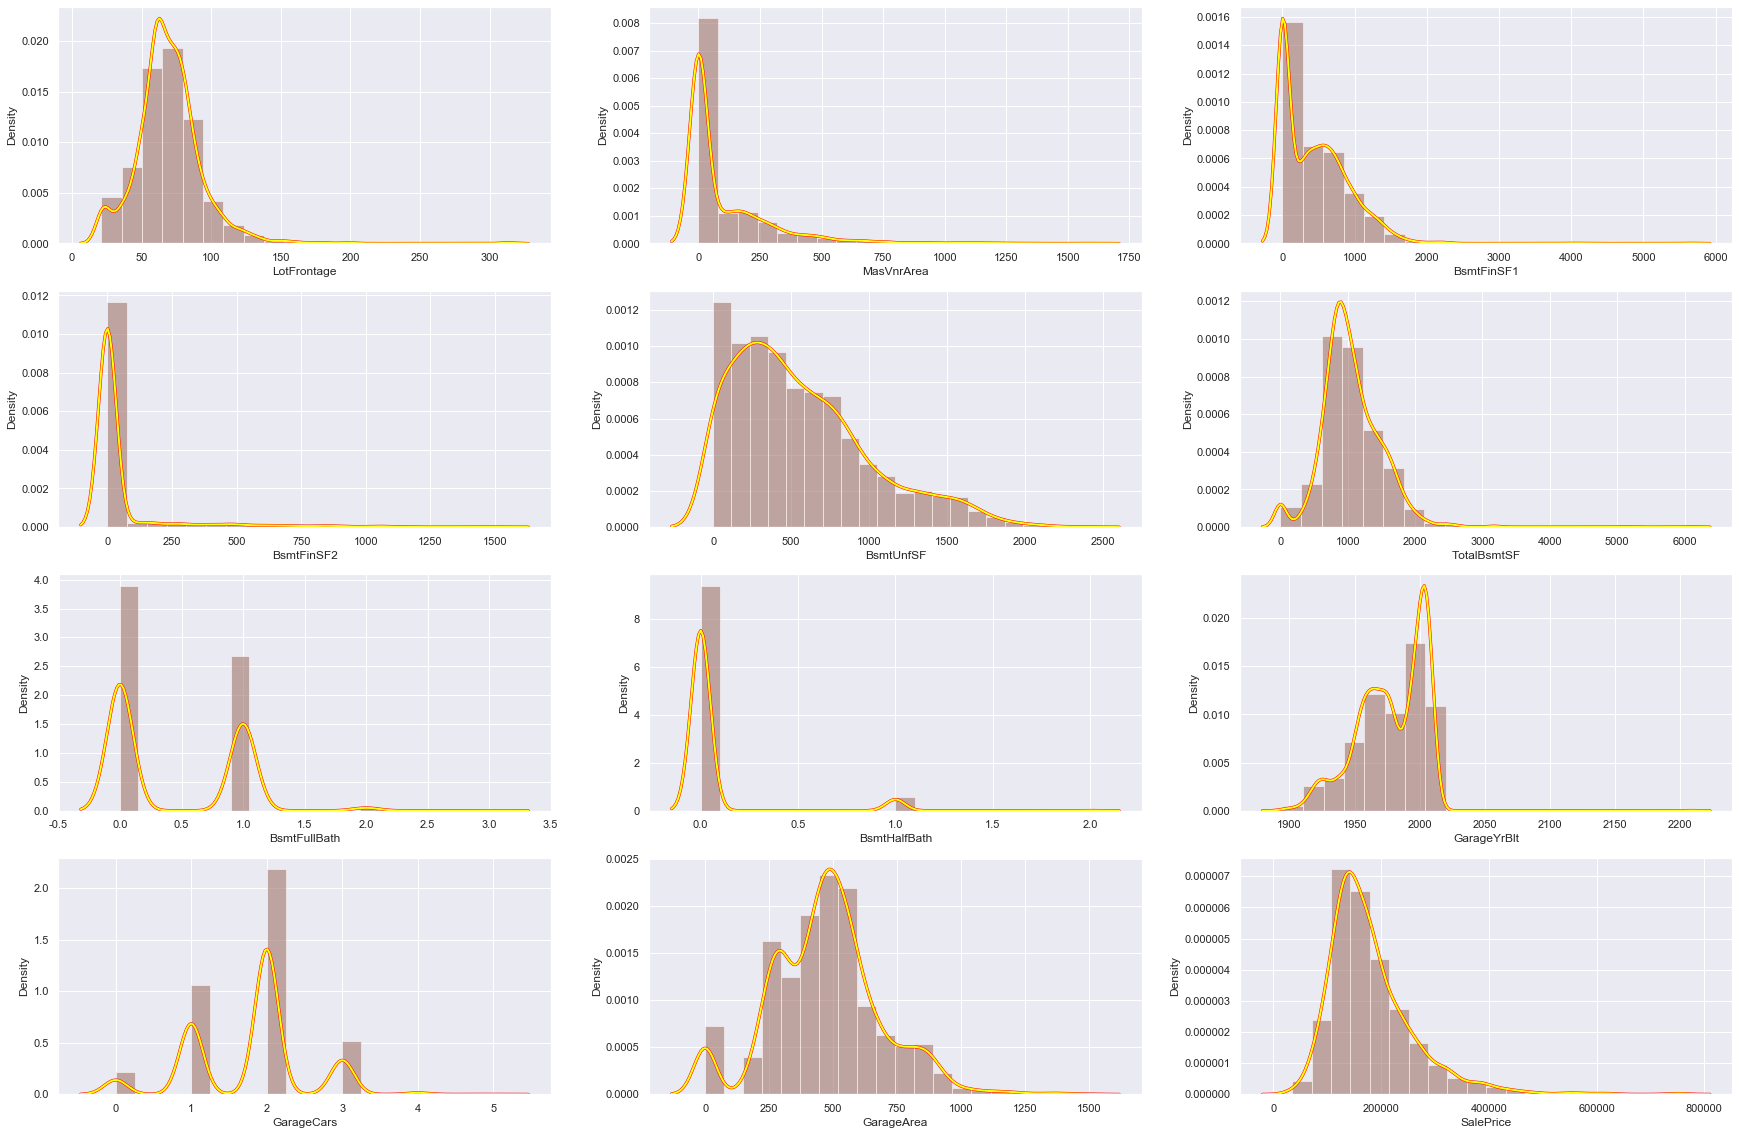

In [102]:
# 检查数值型数据的分布特征并填充均值
null_features_numerical = [col for col in combined_df.columns if combined_df[col].isnull().sum()>0 and col not in categorical_features]
plt.figure(figsize=(30,20))
sns.set()

warnings.simplefilter('ignore')
for i,var in enumerate(null_features_numerical):
    plt.subplot(4,3,i+1)
    sns.distplot(combined_df[var],bins=20,kde_kws={'linewidth':3,'color':'red'},label="original")
    sns.distplot(combined_df[var],bins=20,kde_kws={'linewidth':2,'color':'yellow'},label="mean")

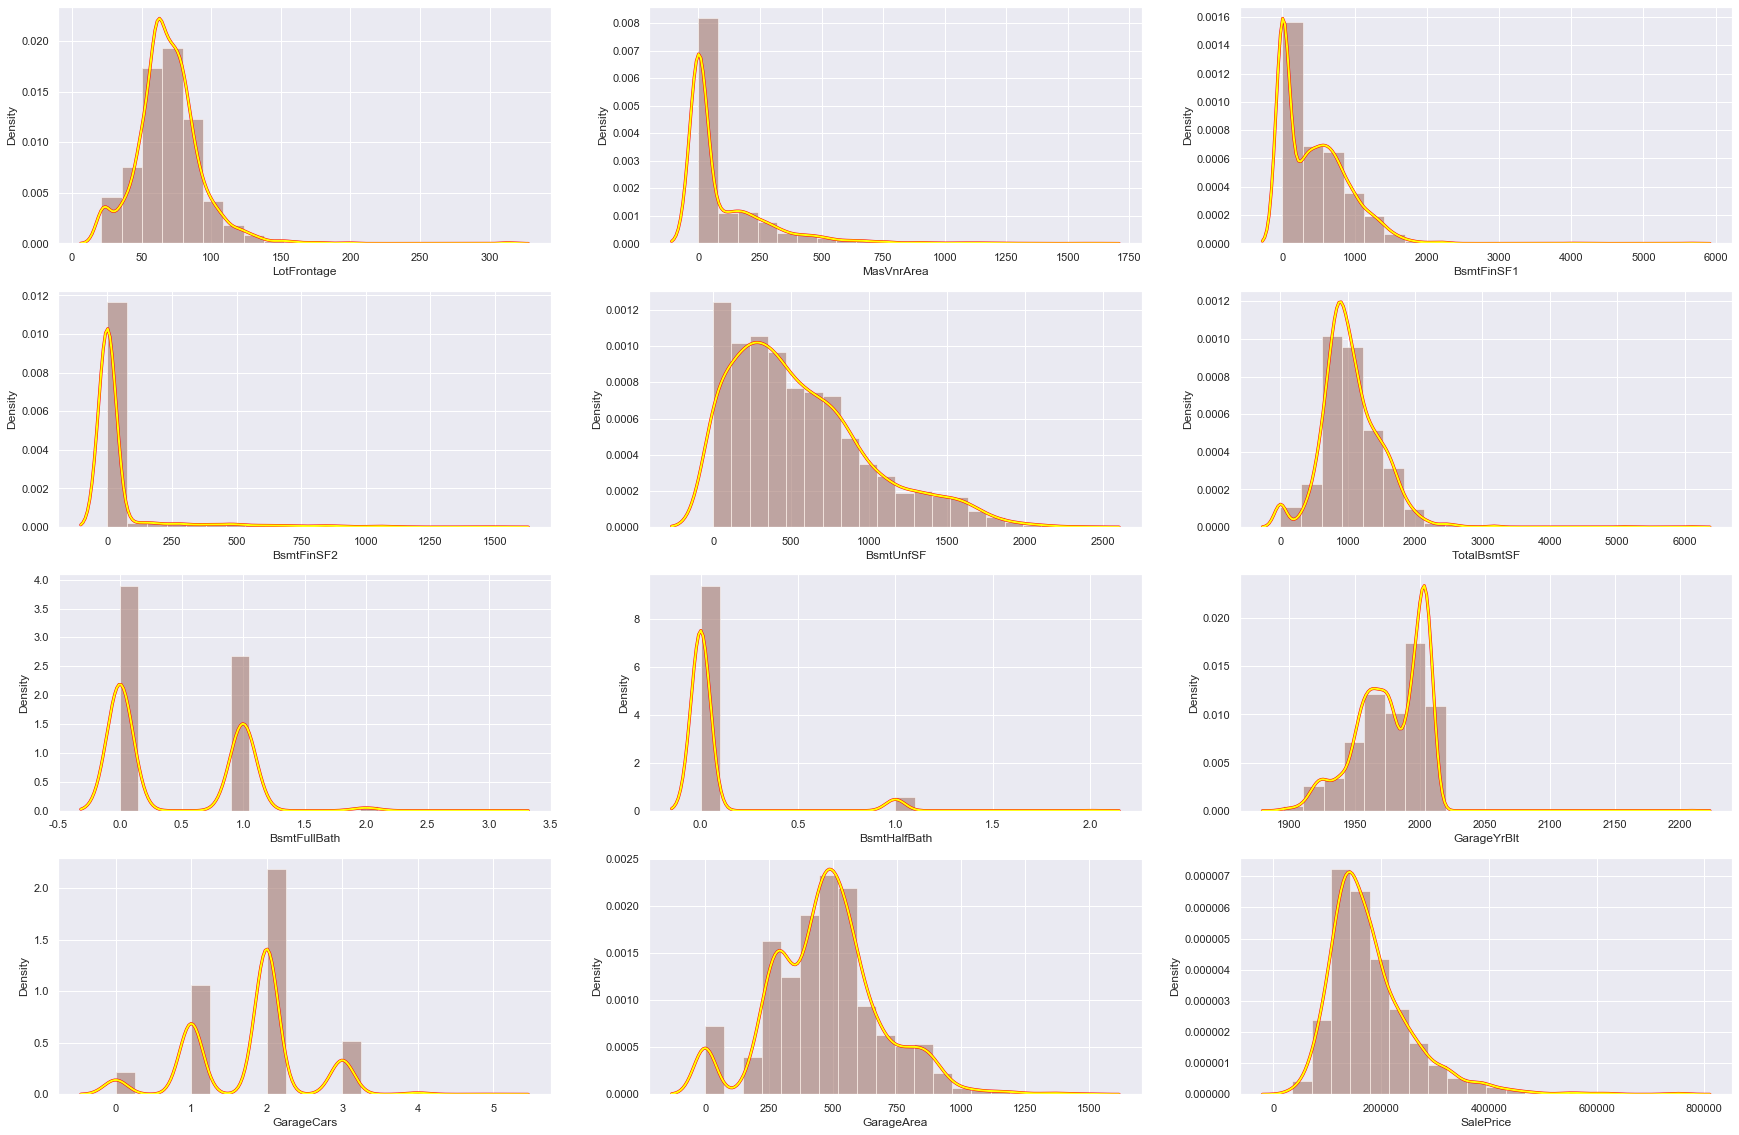

In [103]:
# # 检查数值型数据的分布特征并填充中位值
plt.figure(figsize=(30,20))
sns.set()
warnings.simplefilter("ignore")
for i,var in enumerate(null_features_numerical):
    plt.subplot(4,3,i+1)
    sns.distplot(combined_df[var],bins=20,kde_kws={'linewidth':3,'color':'red'},label="original")
    sns.distplot(combined_df[var],bins=20,kde_kws={'linewidth':2,'color':'yellow'},label="median")

In [104]:
year_feature = [col for col in combined_df.columns if "Yr" in col or 'Year' in col]
year_feature

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

Text(0.5, 1.0, 'House price vs YearSold')

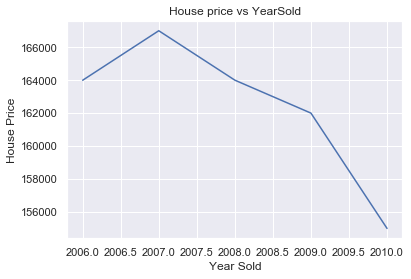

In [105]:
# 然后检查一下这些特征与销售价格是否有关系
combined_df.groupby('YrSold')['SalePrice'].median().plot() # groupby().median()表示取每一组的中位数
plt.xlabel('Year Sold')
plt.ylabel('House Price')
plt.title('House price vs YearSold')

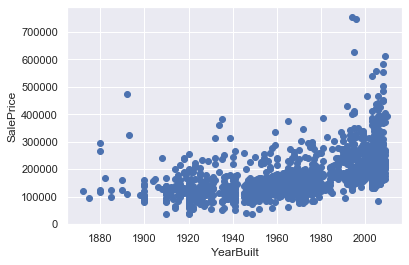

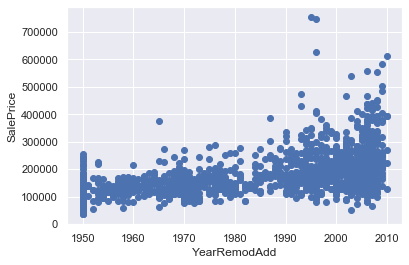

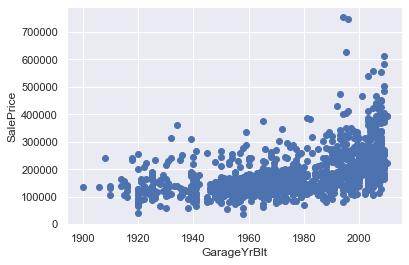

In [106]:
# 绘制其他三个特征与销售价格的散点对应图
# 可以看到随着时间的增加，价格是逐增加的
for feature in year_feature:
    if feature != 'YrSold':
        hs = combined_df.copy()
        plt.scatter(hs[feature],hs['SalePrice'])
        plt.xlabel(feature)
        plt.ylabel('SalePrice')
        plt.show()

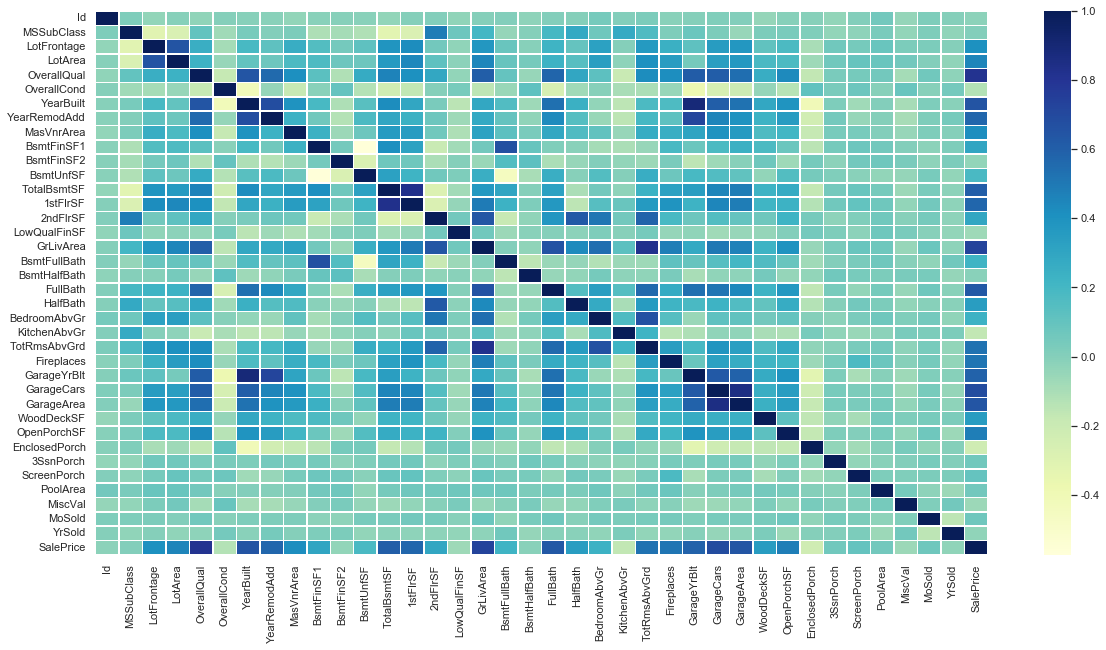

In [107]:
# 使用热力图查看特征之间的相互关系
corrmat = train_data.corr(method='spearman') # 计算不同数据之间的相系数
plt.figure(figsize=(20,10))
sns.heatmap(corrmat,cmap="YlGnBu", linewidths=.5)

In [2]:
train_data.shape

(1460, 81)

In [3]:
test_data.shape

(1459, 80)

In [4]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.00,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.00,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
train_data['SalePrice'].describe()

count     1460.00
mean    180921.20
std      79442.50
min      34900.00
25%     129975.00
50%     163000.00
75%     214000.00
max     755000.00
Name: SalePrice, dtype: float64

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

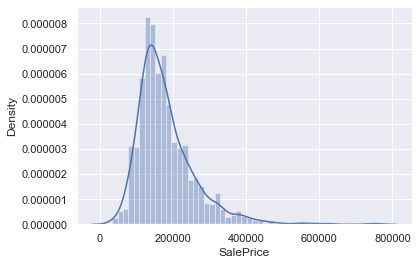

In [8]:
sns.distplot(train_data['SalePrice'])

In [9]:
print("峰度(kurtosis)为：{}".format(train_data['SalePrice'].kurt()))

峰度(kurtosis)为：6.536281860064529


In [10]:
print("偏度(skewness)为：{}".format(train_data['SalePrice'].skew()))

偏度(skewness)为：1.8828757597682129


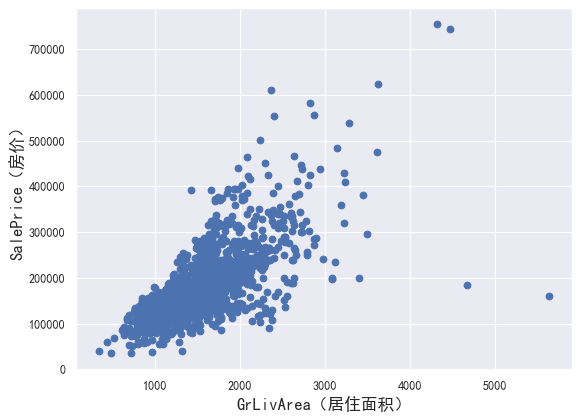

In [11]:
plt.figure(figsize=(8,6),dpi=80,num=4)
plt.rcParams['font.sans-serif']=['SimHei']
plt.scatter(x=train_data['GrLivArea'], y=train_data['SalePrice'])
plt.xlabel('GrLivArea（居住面积）', fontsize=15)
plt.ylabel('SalePrice（房价）', fontsize=15)
plt.show()

In [12]:
train_data.drop('Id', axis=1, inplace=True)
test_data.drop('Id', axis=1, inplace=True)
#删除ID列

In [13]:
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<200000)].index)
#删除右下角两个离群点

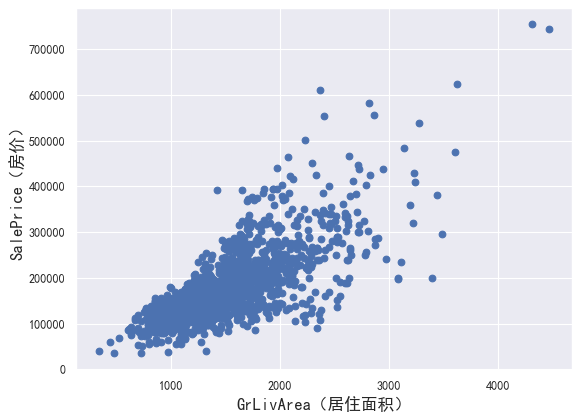

In [14]:
#查看删除后结果
plt.figure(figsize=(8,6),dpi=80,num=4)
plt.rcParams['font.sans-serif']=['SimHei']
plt.scatter(x=train_data['GrLivArea'], y=train_data['SalePrice'])
plt.xlabel('GrLivArea（居住面积）', fontsize=15)
plt.ylabel('SalePrice（房价）', fontsize=15)
plt.show()


 mu=180932.92 and sigma=79467.79 



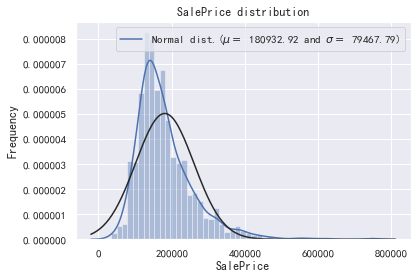

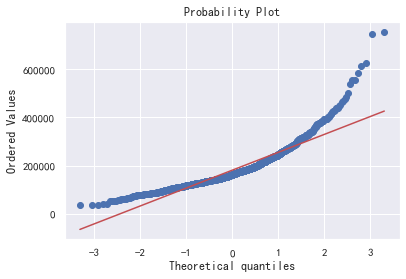

In [15]:
from scipy.stats import norm, skew
from scipy import stats

plt.rcParams['axes.unicode_minus']=False 
sns.distplot(train_data['SalePrice'], fit=norm)

(mu, sigma) = norm.fit(train_data['SalePrice'])
print('\n mu={:.2f} and sigma={:.2f} \n'.format(mu, sigma))
#正态分布转换前房价的均值和标准差

plt.legend(['Normal dist.($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
stats.probplot(train_data['SalePrice'], plot=plt)
plt.show()
#画出Q-Q图，x轴是正态分布的分位数，y轴为样本分位数，如果点在一条直线上，那么证明样本数据服从正态分布

In [16]:
train_data['SalePrice'] = np.log1p(train_data['SalePrice']) #正态分布转换


 mu=12.02 and sigma=0.40 



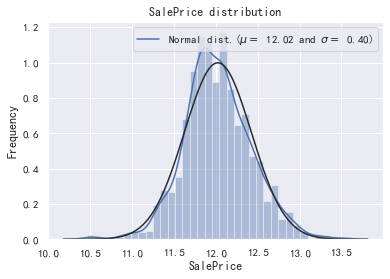

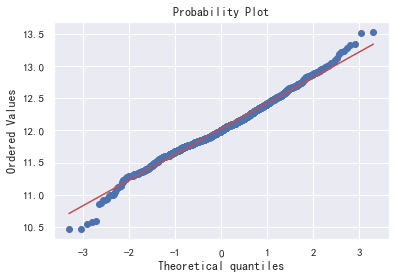

In [17]:
plt.rcParams['axes.unicode_minus']=False 
sns.distplot(train_data['SalePrice'], fit=norm)

(mu, sigma) = norm.fit(train_data['SalePrice'])
print('\n mu={:.2f} and sigma={:.2f} \n'.format(mu, sigma))

plt.legend(['Normal dist.($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
stats.probplot(train_data['SalePrice'], plot=plt)
plt.show()
#Q-Q图显示我们的训练集已满足正态分布的要求

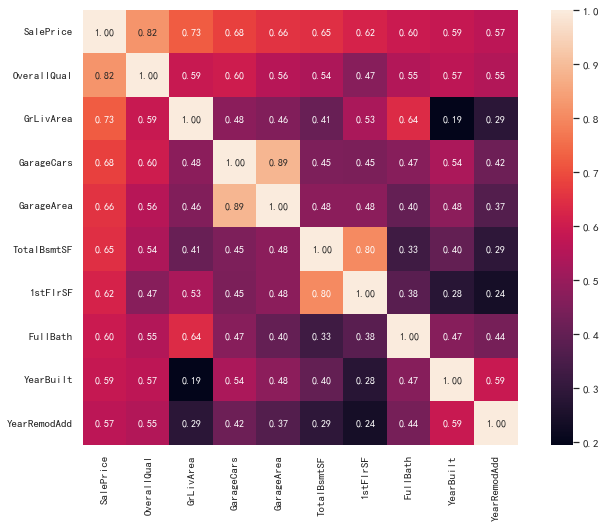

In [18]:
corrmat = train_data.corr()
plt.subplots(figsize=(12,8))
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_data[cols].values.T)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

In [19]:
train_data[cols].columns #与房价相关性最高的前十个特征

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd'],
      dtype='object')

In [20]:
train_data.isnull().sum().sort_values(ascending=False).head(10) #查看缺失值情况

PoolQC          1452
MiscFeature     1404
Alley           1367
Fence           1177
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageCond        81
GarageFinish      81
GarageQual        81
dtype: int64

In [21]:
train_data.isnull().sum().sort_values(ascending=False).head(10)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageFinish      78
GarageYrBlt       78
GarageQual        78
dtype: int64

In [22]:
ntrain = train_data.shape[0]
ntest = test_data.shape[0]
y_train = train_data.SalePrice.values
df_all = pd.concat((train_data,test_data)).reset_index(drop=True)
df_all.drop(['SalePrice'], axis=1, inplace=True)

In [23]:
print("新数据表的维度为：{}".format(df_all.shape))

新数据表的维度为：(2917, 79)


In [24]:
#查看数据缺失率
df_all_na = (df_all.isnull().sum()/len(df_all))
df_all_na = df_all_na.drop(df_all_na[df_all_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({"数据缺失程度" : df_all_na})
missing_data.head(10)

,数据缺失程度
PoolQC,1.00
MiscFeature,0.96
Alley,0.93
Fence,0.80
FireplaceQu,0.49
LotFrontage,0.17
GarageFinish,0.05
GarageYrBlt,0.05
GarageQual,0.05
GarageCond,0.05


Text(0.5, 1.0, '缺失率')

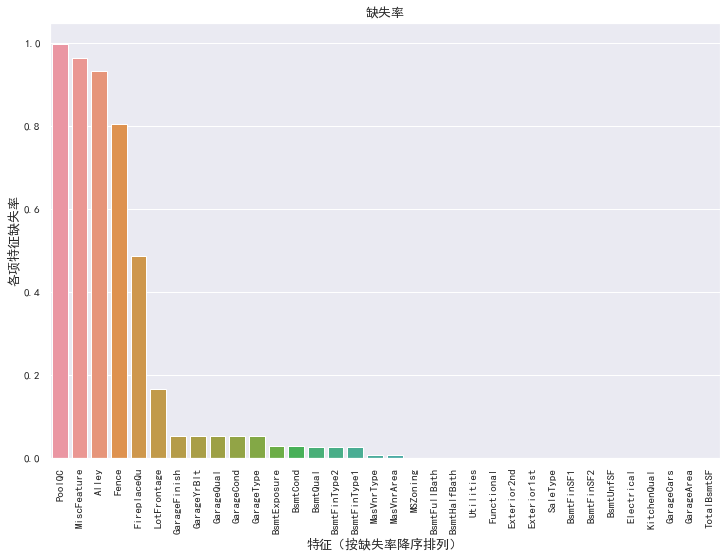

In [25]:
fig = plt.figure(figsize=(12,8))
plt.xticks(rotation='90')
sns.barplot(x=df_all_na.index, y=df_all_na)
plt.xlabel("特征（按缺失率降序排列）", fontsize = 13)
plt.ylabel('各项特征缺失率', fontsize=13)
plt.title('缺失率', fontsize=13)

In [26]:
#缺失值填充
feature1 = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 
            'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 
            'BsmtExposure','BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass']
for i in feature1:
    df_all[i] = df_all[i].fillna('None')
    
feature2 = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 
            'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']
for i in feature2:
    df_all[i] = df_all[i].fillna(0)

feature3 = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for i in feature3:
    df_all[i] = df_all[i].fillna(df_all[i].mode()[0])
    
df_all['LotFrontage'] = df_all.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df_all = df_all.drop(['Utilities'], axis=1)
df_all['Functional'] = df_all['Functional'].fillna('Typ')

In [27]:
df_all_na = (df_all.isnull().sum()/len(df_all))
df_all_na = df_all_na.drop(df_all_na[df_all_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({"数据缺失程度" : df_all_na})
missing_data.head(10)

,数据缺失程度


In [28]:
cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond',
        'HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence',
        'BsmtExposure', 'GarageFinish', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'Alley',
        'CentralAir', 'MSSubClass', 'OverallCond', 'YrSold', 'MoSold']
#编码数据

In [29]:
df_all[cols].head()

,FireplaceQu,BsmtQual,BsmtCond,GarageQual,GarageCond,ExterQual,ExterCond,HeatingQC,PoolQC,KitchenQual,...,LandSlope,LotShape,PavedDrive,Street,Alley,CentralAir,MSSubClass,OverallCond,YrSold,MoSold
0,None,Gd,TA,TA,TA,Gd,TA,Ex,None,Gd,...,Gtl,Reg,Y,Pave,None,Y,60,5,2008,2
1,TA,Gd,TA,TA,TA,TA,TA,Ex,None,TA,...,Gtl,Reg,Y,Pave,None,Y,20,8,2007,5
2,TA,Gd,TA,TA,TA,Gd,TA,Ex,None,Gd,...,Gtl,IR1,Y,Pave,None,Y,60,5,2008,9
3,Gd,TA,Gd,TA,TA,TA,TA,Gd,None,Gd,...,Gtl,IR1,Y,Pave,None,Y,70,5,2006,2
4,TA,Gd,TA,TA,TA,Gd,TA,Ex,None,Gd,...,Gtl,IR1,Y,Pave,None,Y,60,5,2008,12


In [30]:
# 将数值类型转化为字符串类型
feature = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']
for i in feature:
    df_all[i] = df_all[i].astype(str)

In [31]:
# 标签编码对不连续的数字或者文本进行编号,转换成连续的数值型变量
from sklearn.preprocessing import LabelEncoder
for c in cols:
    le = LabelEncoder()
    le.fit(list(df_all[c].values))
    df_all[c] = le.transform(list(df_all[c].values))

In [32]:
df_all[cols].head()

,FireplaceQu,BsmtQual,BsmtCond,GarageQual,GarageCond,ExterQual,ExterCond,HeatingQC,PoolQC,KitchenQual,...,LandSlope,LotShape,PavedDrive,Street,Alley,CentralAir,MSSubClass,OverallCond,YrSold,MoSold
0,3,2,4,5,5,2,4,0,3,2,...,0,3,2,1,1,1,10,4,2,4
1,5,2,4,5,5,3,4,0,3,3,...,0,3,2,1,1,1,5,7,1,7
2,5,2,4,5,5,2,4,0,3,2,...,0,0,2,1,1,1,10,4,2,11
3,2,4,1,5,5,3,4,2,3,2,...,0,0,2,1,1,1,11,4,0,4
4,5,2,4,5,5,2,4,0,3,2,...,0,0,2,1,1,1,10,4,2,3


In [33]:
pd.set_option('max_columns', 80)
df_all.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,10,RL,65.00,8450,1,1,3,Lvl,Inside,0,CollgCr,Norm,Norm,1Fam,2Story,7,4,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,2,4,PConc,2,4,3,2,706.00,6,0.00,150.00,856.00,GasA,0,1,SBrkr,856,854,0,1710,1.00,0.00,2,1,3,1,2,8,6,0,3,Attchd,2003.00,2,2.00,548.00,5,5,2,0,61,0,0,0,0,3,4,None,0,4,2,WD,Normal
1,5,RL,80.00,9600,1,1,3,Lvl,FR2,0,Veenker,Feedr,Norm,1Fam,1Story,6,7,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,3,4,CBlock,2,4,1,0,978.00,6,0.00,284.00,1262.00,GasA,0,1,SBrkr,1262,0,0,1262,0.00,1.00,2,0,3,1,3,6,6,1,5,Attchd,1976.00,2,2.00,460.00,5,5,2,298,0,0,0,0,0,3,4,None,0,7,1,WD,Normal
2,10,RL,68.00,11250,1,1,0,Lvl,Inside,0,CollgCr,Norm,Norm,1Fam,2Story,7,4,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,2,4,PConc,2,4,2,2,486.00,6,0.00,434.00,920.00,GasA,0,1,SBrkr,920,866,0,1786,1.00,0.00,2,1,3,1,2,6,6,1,5,Attchd,2001.00,2,2.00,608.00,5,5,2,0,42,0,0,0,0,3,4,None,0,11,2,WD,Normal
3,11,RL,60.00,9550,1,1,0,Lvl,Corner,0,Crawfor,Norm,Norm,1Fam,2Story,7,4,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,3,4,BrkTil,4,1,3,0,216.00,6,0.00,540.00,756.00,GasA,2,1,SBrkr,961,756,0,1717,1.00,0.00,1,0,3,1,2,7,6,1,2,Detchd,1998.00,3,3.00,642.00,5,5,2,0,35,272,0,0,0,3,4,None,0,4,0,WD,Abnorml
4,10,RL,84.00,14260,1,1,0,Lvl,FR2,0,NoRidge,Norm,Norm,1Fam,2Story,8,4,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,2,4,PConc,2,4,0,2,655.00,6,0.00,490.00,1145.00,GasA,0,1,SBrkr,1145,1053,0,2198,1.00,0.00,2,1,4,1,2,9,6,1,5,Attchd,2000.00,2,3.00,836.00,5,5,2,192,84,0,0,0,0,3,4,None,0,3,2,WD,Normal


In [34]:
df_all['TotalSF'] = df_all['TotalBsmtSF'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']
#增加特征

In [35]:
df_all.dtypes[df_all.dtypes != 'object'].index
#倾斜特征

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'PoolQC', 'Fence', 'MiscVal', 'MoSold', 'YrSold', 'TotalSF'],
      dtype='object')

In [36]:
#计算特征偏度
numeric_feats = df_all.dtypes[df_all.dtypes != 'object'].index
skewed_feats = df_all[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew':skewed_feats})
skewness.head(10)

,Skew
MiscVal,21.94
PoolArea,17.69
LotArea,13.11
LowQualFinSF,12.08
3SsnPorch,11.37
LandSlope,4.97
KitchenAbvGr,4.30
BsmtFinSF2,4.14
EnclosedPorch,4.00
ScreenPorch,3.95


In [37]:
# 对偏态分布的数据进行标准化处理，使其更加服从正态分布
from scipy.special import boxcox1p
skewness = skewness[abs(skewness) > 0.75]
print('There are {} skewed numerical features to Box Cox transform'.format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    df_all[feat] = boxcox1p(df_all[feat], lam)
    
# all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


In [38]:
df_all.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF
0,2.89,RL,5.83,19.21,0.73,0.73,1.54,Lvl,Inside,0.00,CollgCr,Norm,Norm,1Fam,2Story,2.44,1.82,14.19,14.19,Gable,CompShg,VinylSd,VinylSd,BrkFace,8.06,1.19,1.82,PConc,1.19,1.82,1.54,1.19,11.17,2.26,0.00,7.48,11.69,GasA,0.00,0.73,SBrkr,11.69,11.69,0.00,13.70,0.73,0.00,1.19,0.73,1.54,0.73,1.19,2.60,2.26,0.00,1.54,Attchd,14.19,1.19,1.19,10.51,2.06,2.06,1.19,0.00,5.71,0.00,0.00,0.00,0.00,1.54,1.82,None,0.00,1.82,1.19,WD,Normal,14.98
1,2.06,RL,6.22,19.71,0.73,0.73,1.54,Lvl,FR2,0.00,Veenker,Feedr,Norm,1Fam,1Story,2.26,2.44,14.15,14.15,Gable,CompShg,MetalSd,MetalSd,None,0.00,1.54,1.82,CBlock,1.19,1.82,0.73,0.00,12.06,2.26,0.00,8.90,12.79,GasA,0.00,0.73,SBrkr,12.79,0.00,0.00,12.79,0.00,0.73,1.19,0.00,1.54,0.73,1.54,2.26,2.26,0.73,2.06,Attchd,14.15,1.19,1.19,10.06,2.06,2.06,1.19,9.01,0.00,0.00,0.00,0.00,0.00,1.54,1.82,None,0.00,2.44,0.73,WD,Normal,14.92
2,2.89,RL,5.91,20.35,0.73,0.73,0.00,Lvl,Inside,0.00,CollgCr,Norm,Norm,1Fam,2Story,2.44,1.82,14.18,14.19,Gable,CompShg,VinylSd,VinylSd,BrkFace,7.65,1.19,1.82,PConc,1.19,1.82,1.19,1.19,10.20,2.26,0.00,9.92,11.89,GasA,0.00,0.73,SBrkr,11.89,11.72,0.00,13.83,0.73,0.00,1.19,0.73,1.54,0.73,1.19,2.26,2.26,0.73,2.06,Attchd,14.18,1.19,1.19,10.78,2.06,2.06,1.19,0.00,5.05,0.00,0.00,0.00,0.00,1.54,1.82,None,0.00,3.01,1.19,WD,Normal,15.15
3,3.01,RL,5.68,19.69,0.73,0.73,0.00,Lvl,Corner,0.00,Crawfor,Norm,Norm,1Fam,2Story,2.44,1.82,14.05,14.14,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,1.54,1.82,BrkTil,1.82,0.73,1.54,0.00,8.27,2.26,0.00,10.47,11.35,GasA,1.19,0.73,SBrkr,12.01,11.35,0.00,13.71,0.73,0.00,0.73,0.00,1.54,0.73,1.19,2.44,2.26,0.73,1.19,Detchd,14.18,1.54,1.54,10.92,2.06,2.06,1.19,0.00,4.75,8.80,0.00,0.00,0.00,1.54,1.82,None,0.00,1.82,0.00,WD,Abnorml,14.86
4,2.89,RL,6.31,21.33,0.73,0.73,0.00,Lvl,FR2,0.00,NoRidge,Norm,Norm,1Fam,2Story,2.60,1.82,14.18,14.18,Gable,CompShg,VinylSd,VinylSd,BrkFace,9.39,1.19,1.82,PConc,1.19,1.82,0.00,1.19,10.97,2.26,0.00,10.22,12.51,GasA,0.00,0.73,SBrkr,12.51,12.27,0.00,14.48,0.73,0.00,1.19,0.73,1.82,0.73,1.19,2.75,2.26,0.73,2.06,Attchd,14.18,1.19,1.54,11.63,2.06,2.06,1.19,8.01,6.31,0.00,0.00,0.00,0.00,1.54,1.82,None,0.00,1.54,1.19,WD,Normal,15.85


In [39]:
#进行独热编码
df_all = pd.get_dummies(df_all)
df_all.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,...,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,2.89,5.83,19.21,0.73,0.73,1.54,0.00,2.44,1.82,14.19,14.19,8.06,1.19,1.82,1.19,1.82,1.54,1.19,11.17,2.26,0.00,7.48,11.69,0.00,0.73,11.69,11.69,0.00,13.70,0.73,0.00,1.19,0.73,1.54,0.73,1.19,2.60,2.26,0.00,1.54,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2.06,6.22,19.71,0.73,0.73,1.54,0.00,2.26,2.44,14.15,14.15,0.00,1.54,1.82,1.19,1.82,0.73,0.00,12.06,2.26,0.00,8.90,12.79,0.00,0.73,12.79,0.00,0.00,12.79,0.00,0.73,1.19,0.00,1.54,0.73,1.54,2.26,2.26,0.73,2.06,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,2.89,5.91,20.35,0.73,0.73,0.00,0.00,2.44,1.82,14.18,14.19,7.65,1.19,1.82,1.19,1.82,1.19,1.19,10.20,2.26,0.00,9.92,11.89,0.00,0.73,11.89,11.72,0.00,13.83,0.73,0.00,1.19,0.73,1.54,0.73,1.19,2.26,2.26,0.73,2.06,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,3.01,5.68,19.69,0.73,0.73,0.00,0.00,2.44,1.82,14.05,14.14,0.00,1.54,1.82,1.82,0.73,1.54,0.00,8.27,2.26,0.00,10.47,11.35,1.19,0.73,12.01,11.35,0.00,13.71,0.73,0.00,0.73,0.00,1.54,0.73,1.19,2.44,2.26,0.73,1.19,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,2.89,6.31,21.33,0.73,0.73,0.00,0.00,2.60,1.82,14.18,14.18,9.39,1.19,1.82,1.19,1.82,0.00,1.19,10.97,2.26,0.00,10.22,12.51,0.00,0.73,12.51,12.27,0.00,14.48,0.73,0.00,1.19,0.73,1.82,0.73,1.19,2.75,2.26,0.73,2.06,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [40]:
train = df_all[:ntrain]
test = df_all[ntrain:]

In [41]:
train.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,...,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,2.89,5.83,19.21,0.73,0.73,1.54,0.00,2.44,1.82,14.19,14.19,8.06,1.19,1.82,1.19,1.82,1.54,1.19,11.17,2.26,0.00,7.48,11.69,0.00,0.73,11.69,11.69,0.00,13.70,0.73,0.00,1.19,0.73,1.54,0.73,1.19,2.60,2.26,0.00,1.54,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2.06,6.22,19.71,0.73,0.73,1.54,0.00,2.26,2.44,14.15,14.15,0.00,1.54,1.82,1.19,1.82,0.73,0.00,12.06,2.26,0.00,8.90,12.79,0.00,0.73,12.79,0.00,0.00,12.79,0.00,0.73,1.19,0.00,1.54,0.73,1.54,2.26,2.26,0.73,2.06,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,2.89,5.91,20.35,0.73,0.73,0.00,0.00,2.44,1.82,14.18,14.19,7.65,1.19,1.82,1.19,1.82,1.19,1.19,10.20,2.26,0.00,9.92,11.89,0.00,0.73,11.89,11.72,0.00,13.83,0.73,0.00,1.19,0.73,1.54,0.73,1.19,2.26,2.26,0.73,2.06,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,3.01,5.68,19.69,0.73,0.73,0.00,0.00,2.44,1.82,14.05,14.14,0.00,1.54,1.82,1.82,0.73,1.54,0.00,8.27,2.26,0.00,10.47,11.35,1.19,0.73,12.01,11.35,0.00,13.71,0.73,0.00,0.73,0.00,1.54,0.73,1.19,2.44,2.26,0.73,1.19,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,2.89,6.31,21.33,0.73,0.73,0.00,0.00,2.60,1.82,14.18,14.18,9.39,1.19,1.82,1.19,1.82,0.00,1.19,10.97,2.26,0.00,10.22,12.51,0.00,0.73,12.51,12.27,0.00,14.48,0.73,0.00,1.19,0.73,1.82,0.73,1.19,2.75,2.26,0.73,2.06,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [42]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

# 使用sklearn中的RoubstScaler函数对异常值鲁棒性的统计信息（中位数和四分位数）进行缩放特征
pre_precessing_pipeline = make_pipeline(RobustScaler(), 
                                        #VarianceThreshold(0.001),
                                       )

X_train = pre_precessing_pipeline.fit_transform(train)
X_test = pre_precessing_pipeline.transform(test)


In [43]:
#调用lazypredict观察多个模型效果
x_train1,x_test1,y_train1,y_test1 = train_test_split(X_train,y_train,test_size=0.25)
reg = LazyRegressor(verbose=0,ignore_warnings=True,custom_metric=None)
train,test = reg.fit(x_train1,x_test1,y_train1,y_test1)
test

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [01:38<00:00,  2.35s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LassoCV,0.80,0.92,0.12,1.76
ElasticNetCV,0.80,0.92,0.12,1.80
LassoLarsCV,0.80,0.92,0.12,1.01
LarsCV,0.80,0.92,0.12,1.74
PoissonRegressor,0.79,0.92,0.12,0.11
BayesianRidge,0.79,0.92,0.12,0.36
RidgeCV,0.79,0.92,0.12,0.37
Ridge,0.78,0.91,0.12,0.09
HuberRegressor,0.78,0.91,0.12,0.64


In [46]:
#定义验证函数，使用均方根误差
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 10))
    return (rmse)

In [47]:
#Lasso
#alphas为备选的alpha，lassocv可以从中自动得到最优alpha
clf_lasso = LassoCV(alphas = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0])
clf_lasso.fit(X_train, y_train)
#保证数据有效性，防止数据太小无法显示
lasso_preds = np.expm1(clf_lasso.predict(X_test))

score_lasso = rmse_cv(clf_lasso)
#std:标准差
print("\nLasso score: {:.4f} ({:.4f})\n".format(score_lasso.mean(), score_lasso.std()))


Lasso score: 0.1099 (0.0140)



In [48]:
#岭回归
clf_ridge = RidgeCV(alphas = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 10, 20])
clf_ridge.fit(X_train, y_train)
ridge_preds = np.expm1(clf_ridge.predict(X_test))

score_ridge = rmse_cv(clf_ridge)
print("\nRidge score: {:.4f} ({:.4f})\n".format(score_ridge.mean(), score_ridge.std()))


Ridge score: 0.1114 (0.0137)



In [49]:
#ElasticNet
clf_en = ElasticNetCV(alphas = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01], l1_ratio = [0.1, 0.2, 0.5, 0.6, 0.8, 0.9])
clf_en.fit(X_train, y_train)
elas_preds = np.expm1(clf_en.predict(X_test))

score_en = rmse_cv(clf_en)
print("\nElasticNet score: {:.4f} ({:.4f})\n".format(score_en.mean(), score_en.std()))


ElasticNet score: 0.1098 (0.0141)



In [50]:
#超参数调整，使用optuna框架
def tune(objective):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective,n_trials=100)
    
    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    return params

In [51]:
#XGBoost
#目标函数
RANDOM_SEED = 1
def xgb_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _gamma = trial.suggest_float("gamma", 0.01, 1)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    _subsample = trial.suggest_float('subsample', 0.01, 1)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)

    
    xgbr = xgb.XGBRegressor(
        n_estimators=_n_estimators,
        max_depth=_max_depth, 
        learning_rate=_learning_rate,
        gamma=_gamma,
        min_child_weight=_min_child_weight,
        subsample=_subsample,
        reg_alpha=_reg_alpha,
        reg_lambda=_reg_lambda,
        random_state=RANDOM_SEED,
    )
    score = cross_val_score(
        xgbr, X_train,y_train, cv=10, scoring="neg_root_mean_squared_error"
    ).mean()
    return score

xgb_params = tune(xgb_objective)

[I 2022-01-09 19:25:31,534] A new study created in memory with name: no-name-53fdead0-7ead-4240-a090-692b13003075
[I 2022-01-09 19:25:46,779] Trial 0 finished with value: -0.1851924734763523 and parameters: {'n_estimators': 955, 'max_depth': 2, 'learning_rate': 0.9818413851986307, 'gamma': 0.43727075002205656, 'min_child_weight': 6.547130076394526, 'subsample': 0.9713396817521763, 'reg_alpha': 6.236016788688624, 'reg_lambda': 5.7622750194612165}. Best is trial 0 with value: -0.1851924734763523.
[I 2022-01-09 19:25:57,754] Trial 1 finished with value: -0.17939519441240484 and parameters: {'n_estimators': 423, 'max_depth': 11, 'learning_rate': 0.21143438433272194, 'gamma': 0.625648569751262, 'min_child_weight': 7.281716553183062, 'subsample': 0.2400932064056545, 'reg_alpha': 6.022739467462407, 'reg_lambda': 5.438291669296359}. Best is trial 1 with value: -0.17939519441240484.
[I 2022-01-09 19:26:25,986] Trial 2 finished with value: -0.2146755578921812 and parameters: {'n_estimators': 136

[I 2022-01-09 19:39:06,556] Trial 21 finished with value: -0.14309563795282465 and parameters: {'n_estimators': 84, 'max_depth': 17, 'learning_rate': 0.30088175835334985, 'gamma': 0.3975571709758015, 'min_child_weight': 7.193728915523641, 'subsample': 0.4894522598917815, 'reg_alpha': 0.2141607238953005, 'reg_lambda': 7.195258398277366}. Best is trial 21 with value: -0.14309563795282465.
[I 2022-01-09 19:39:25,668] Trial 22 finished with value: -0.14890524640084482 and parameters: {'n_estimators': 383, 'max_depth': 17, 'learning_rate': 0.30339195197201607, 'gamma': 0.5311355407707107, 'min_child_weight': 8.161824694849997, 'subsample': 0.36597308397053574, 'reg_alpha': 0.06730038061952207, 'reg_lambda': 9.965620415570717}. Best is trial 21 with value: -0.14309563795282465.
[I 2022-01-09 19:40:14,639] Trial 23 finished with value: -0.1374308992964003 and parameters: {'n_estimators': 847, 'max_depth': 13, 'learning_rate': 0.20202547464584256, 'gamma': 0.25966795323566216, 'min_child_weigh

[I 2022-01-09 19:51:42,901] Trial 42 finished with value: -0.12928206564175843 and parameters: {'n_estimators': 209, 'max_depth': 10, 'learning_rate': 0.06720717009417812, 'gamma': 0.010661642568630836, 'min_child_weight': 2.6340746506032344, 'subsample': 0.9362649154218805, 'reg_alpha': 5.18584262674207, 'reg_lambda': 2.52515135259256}. Best is trial 42 with value: -0.12928206564175843.
[I 2022-01-09 19:51:54,204] Trial 43 finished with value: -0.12963683350643887 and parameters: {'n_estimators': 196, 'max_depth': 10, 'learning_rate': 0.07899931537717339, 'gamma': 0.017836767052161813, 'min_child_weight': 4.550939087291243, 'subsample': 0.9535679483022755, 'reg_alpha': 4.9947576537369365, 'reg_lambda': 3.8087365197800462}. Best is trial 42 with value: -0.12928206564175843.
[I 2022-01-09 19:52:05,873] Trial 44 finished with value: -0.13221232769145397 and parameters: {'n_estimators': 185, 'max_depth': 12, 'learning_rate': 0.15705113617040284, 'gamma': 0.013485162658261798, 'min_child_w

[I 2022-01-09 20:01:52,416] Trial 63 finished with value: -0.132839246114723 and parameters: {'n_estimators': 84, 'max_depth': 8, 'learning_rate': 0.09889328036450401, 'gamma': 0.0699655441706791, 'min_child_weight': 5.198802633468485, 'subsample': 0.8698414976081971, 'reg_alpha': 3.4998285223682837, 'reg_lambda': 2.5280311951855237}. Best is trial 42 with value: -0.12928206564175843.
[I 2022-01-09 20:02:13,738] Trial 64 finished with value: -0.13206644245534366 and parameters: {'n_estimators': 360, 'max_depth': 10, 'learning_rate': 0.04995976946253125, 'gamma': 0.08843326948524596, 'min_child_weight': 5.703324203107088, 'subsample': 0.935766653977506, 'reg_alpha': 4.543476967748128, 'reg_lambda': 1.8215858975085242}. Best is trial 42 with value: -0.12928206564175843.
[I 2022-01-09 20:02:36,231] Trial 65 finished with value: -0.1315608856725947 and parameters: {'n_estimators': 354, 'max_depth': 10, 'learning_rate': 0.11980496682320425, 'gamma': 0.04882987323089191, 'min_child_weight': 

[I 2022-01-09 20:10:52,830] Trial 84 finished with value: -0.13328763323690654 and parameters: {'n_estimators': 213, 'max_depth': 9, 'learning_rate': 0.08439688764731543, 'gamma': 0.08183964794459596, 'min_child_weight': 8.668204729424188, 'subsample': 0.9646265809802684, 'reg_alpha': 3.949666999673709, 'reg_lambda': 2.370279548731146}. Best is trial 83 with value: -0.12920041351159856.
[I 2022-01-09 20:11:08,326] Trial 85 finished with value: -0.12769158663442845 and parameters: {'n_estimators': 261, 'max_depth': 11, 'learning_rate': 0.06171767443447598, 'gamma': 0.0344220791312583, 'min_child_weight': 7.315517661090865, 'subsample': 0.8935203245106881, 'reg_alpha': 3.2199173718377754, 'reg_lambda': 2.0062548991009765}. Best is trial 85 with value: -0.12769158663442845.
[I 2022-01-09 20:11:10,853] Trial 86 finished with value: -0.3718685054663977 and parameters: {'n_estimators': 109, 'max_depth': 11, 'learning_rate': 0.0325454774937817, 'gamma': 0.11261582429957726, 'min_child_weight'

Best score: -0.12620168048400926 
Optimized parameters: {'n_estimators': 242, 'max_depth': 11, 'learning_rate': 0.063240608037147, 'gamma': 0.018400603767069035, 'min_child_weight': 7.776063920611367, 'subsample': 0.8918358575346695, 'reg_alpha': 3.5532409719812144, 'reg_lambda': 0.8675471544593278}


In [52]:
#计算效果
xgb_params = {'n_estimators': 242, 'max_depth': 11, 'learning_rate': 0.063240608037147, 'gamma': 0.018400603767069035, 'min_child_weight': 7.776063920611367, 'subsample': 0.8918358575346695, 'reg_alpha': 3.5532409719812144, 'reg_lambda': 0.8675471544593278}
clf_xgb = xgb.XGBRegressor(random_state=RANDOM_SEED, **xgb_params)
clf_xgb.fit(X_train,y_train)
xgb_preds = np.expm1(clf_xgb.predict(X_test))
 
score_xgb = rmse_cv(clf_xgb)
print("\nxgb score: {:.4f} ({:.4f})\n".format(score_xgb.mean(), score_xgb.std()))


xgb score: 0.1262 (0.0130)



In [53]:
#梯度提升
def gbr_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 20)
    _max_features = trial.suggest_int("max_features", 10, 50)

    gbr = GradientBoostingRegressor(
        n_estimators=_n_estimators,
        learning_rate=_learning_rate,
        max_depth=_max_depth, 
        max_features=_max_features,
        min_samples_leaf=_min_samples_leaf,
        min_samples_split=_min_samples_split,
        
        random_state=RANDOM_SEED,
    )

    score = cross_val_score(
        gbr, X_train,y_train, cv=10, scoring="neg_root_mean_squared_error"
    ).mean()
    return score

gbr_params = tune(gbr_objective)

[I 2022-01-09 20:16:06,035] A new study created in memory with name: no-name-9ec52700-ee4b-4d31-ae9f-85496439a965
[I 2022-01-09 20:16:33,322] Trial 0 finished with value: -0.1736004148815625 and parameters: {'n_estimators': 1033, 'learning_rate': 0.7448843689708197, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 18, 'max_features': 23}. Best is trial 0 with value: -0.1736004148815625.
[I 2022-01-09 20:17:28,619] Trial 1 finished with value: -0.16705117929650717 and parameters: {'n_estimators': 1499, 'learning_rate': 0.663786717137219, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 15, 'max_features': 23}. Best is trial 1 with value: -0.16705117929650717.
[I 2022-01-09 20:18:36,425] Trial 2 finished with value: -0.1337292047980449 and parameters: {'n_estimators': 1833, 'learning_rate': 0.2949913807820352, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 35}. Best is trial 2 with value: -0.1337292047980449.
[I 2022-01-09 20:18:41,

[I 2022-01-09 20:28:17,486] Trial 27 finished with value: -0.11984925134562081 and parameters: {'n_estimators': 870, 'learning_rate': 0.04209303643407554, 'max_depth': 11, 'min_samples_split': 20, 'min_samples_leaf': 11, 'max_features': 26}. Best is trial 25 with value: -0.11436552685901916.
[I 2022-01-09 20:29:06,971] Trial 28 finished with value: -0.12371487242798643 and parameters: {'n_estimators': 1735, 'learning_rate': 0.13788791521998311, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 36}. Best is trial 25 with value: -0.11436552685901916.
[I 2022-01-09 20:29:45,034] Trial 29 finished with value: -0.12489500344680252 and parameters: {'n_estimators': 1178, 'learning_rate': 0.08926540513986211, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 23}. Best is trial 25 with value: -0.11436552685901916.
[I 2022-01-09 20:30:48,220] Trial 30 finished with value: -0.11690275923134066 and parameters: {'n_estimators': 1359, 'lea

[I 2022-01-09 20:44:10,378] Trial 54 finished with value: -0.11951384116514434 and parameters: {'n_estimators': 1900, 'learning_rate': 0.08806792255731527, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 12, 'max_features': 33}. Best is trial 51 with value: -0.11344691999214884.
[I 2022-01-09 20:44:21,903] Trial 55 finished with value: -0.14466732113514755 and parameters: {'n_estimators': 1053, 'learning_rate': 0.714989358141164, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': 28}. Best is trial 51 with value: -0.11344691999214884.
[I 2022-01-09 20:44:43,339] Trial 56 finished with value: -0.12337102701291824 and parameters: {'n_estimators': 1150, 'learning_rate': 0.1893974959958585, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 37}. Best is trial 51 with value: -0.11344691999214884.
[I 2022-01-09 20:45:16,618] Trial 57 finished with value: -0.12020317031024474 and parameters: {'n_estimators': 1270, 'learning

[I 2022-01-09 20:50:45,622] Trial 81 finished with value: -0.11413404924971778 and parameters: {'n_estimators': 1323, 'learning_rate': 0.09658271043684553, 'max_depth': 1, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 23}. Best is trial 71 with value: -0.11080329273361575.
[I 2022-01-09 20:50:52,519] Trial 82 finished with value: -0.1145468658227973 and parameters: {'n_estimators': 1384, 'learning_rate': 0.12207921398031515, 'max_depth': 1, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 17}. Best is trial 71 with value: -0.11080329273361575.
[I 2022-01-09 20:51:00,141] Trial 83 finished with value: -0.11397806272834662 and parameters: {'n_estimators': 1325, 'learning_rate': 0.06538437207575694, 'max_depth': 1, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 22}. Best is trial 71 with value: -0.11080329273361575.
[I 2022-01-09 20:51:15,319] Trial 84 finished with value: -0.11407034535384189 and parameters: {'n_estimators': 1225, 'learnin

Best score: -0.10975959134859466 
Optimized parameters: {'n_estimators': 1122, 'learning_rate': 0.0362725462022589, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 23}


In [54]:
gbr_params = {'n_estimators': 1122, 'learning_rate': 0.0362725462022589, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 23}
clf_gbr = GradientBoostingRegressor(random_state=RANDOM_SEED, **gbr_params)
clf_gbr.fit(X_train,y_train)
gbr_preds = np.expm1(clf_gbr.predict(X_test))
 
score_gbr = rmse_cv(clf_gbr)
print("\ngbr score: {:.4f} ({:.4f})\n".format(score_gbr.mean(), score_gbr.std()))


gbr score: 0.1098 (0.0168)



In [ ]:
#模型融合
final_result = 0.3*lasso_preds + 0.4*gbr_preds + 0.1*xgb_preds +0.1*ridge_preds + 0.1*elas_preds
#solution = pd.DataFrame({"id":test.index+1461, "SalePrice":final_result}, columns=['id', 'SalePrice'])
#solution.to_csv("result.csv", index = False)